In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
class MahalanobisLayer:
    def __init__(self, alpha=1e-5):
        self.centroids = None
        self.covariance_inv = None
        self.class_labels = None
        self.alpha = alpha  # Regularization for covariance stability

    def fit(self, X_train, y_train):
        self.class_labels = np.unique(y_train)
        self.centroids = []
        self.covariance_inv = []
        for label in self.class_labels:
            class_data = X_train[y_train == label]
            centroid = np.mean(class_data, axis=0)
            cov = np.cov(class_data.T) + np.eye(class_data.shape[1]) * self.alpha
            self.centroids.append(centroid)
            self.covariance_inv.append(np.linalg.inv(cov))
        return self
    def predict(self, X):
        n_classes = len(self.centroids)
        predictions = []
        for x in X:
            distances = np.zeros((n_classes, n_classes))
            for j in range(n_classes):  # Centroid index
                for k in range(n_classes):  # Covariance index
                    distances[j, k] = mahalanobis(x, self.centroids[j], self.covariance_inv[k])
            distances = np.where(np.isnan(distances), float('inf'), distances)
            predictions.append(distances.flatten())
        return np.array(predictions)
class MultiLayerMahalanobis:
    def __init__(self, n_layers=2, alpha=1e-5, n_neighbors=1):
        self.layers = [MahalanobisLayer(alpha) for _ in range(n_layers)]
        #self.preprocessor = DataPreprocessor()
        self.n_layers = n_layers
        self.n_neighbors = n_neighbors
        self.X_train_features = None
        self.y_train = None
        self.class_labels = None

    def gelu(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

    def fit(self, X_current, y_train):
        #X_current = self.preprocessor.preprocess(X_train, fit_scalers=True)
        for i, layer in enumerate(self.layers):
            layer.fit(X_current, y_train)
            X_current = layer.predict(X_current)
            if i < self.n_layers - 1:
                X_current = self.gelu(X_current)
        self.X_train_features = X_current
        self.y_train = y_train
        self.class_labels = np.unique(y_train)
        return self

    def predict(self, X_test,thresholds,a,b,labels):
        
        X_current = X_test[:]
        for i, layer in enumerate(self.layers):
            X_current = layer.predict(X_current)
            # if i < self.n_layers - 1:
            #     X_current = self.gelu(X_current)
        X_test_features = X_current

        # Relational classification using wvRN
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='cosine')
        nn.fit(self.X_train_features)
        distances, indices = nn.kneighbors(X_test_features)
        weights = 1 - distances  # Convert distance to similarity

        y_pred = []
        for i in range(len(X_test_features)):
            dists = np.array([mahalanobis(X_test[i], a[j], b[j]) for j in range(len(a))])
            min_idx = np.argmin(dists)
            min_dist = dists[min_idx]
            pred_label = labels[min_idx]
            if min_dist > thresholds[pred_label]:
                 y_pred.append(5)
            else:
                neighbor_labels = self.y_train.iloc[indices[i]]
                neighbor_weights = weights[i]
                class_weights = {c: np.sum(neighbor_weights[neighbor_labels == c]) 
                                 for c in self.class_labels}
                total_weight = np.sum(neighbor_weights)
                predicted_class = max(class_weights, key=lambda c: class_weights[c] / total_weight if total_weight > 0 else 0)
                y_pred.append(predicted_class)
        return np.array(y_pred)
    def predict1(self, X_current):
        for i, layer in enumerate(self.layers):
            X_current = layer.predict(X_current)
            # if i < self.n_layers - 1:
            #     X_current = self.gelu(X_current)
        X_test_features = X_current

        # Relational classification using wvRN
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='cosine')
        nn.fit(self.X_train_features)
        distances, indices = nn.kneighbors(X_test_features)
        weights = 1 - distances  # Convert distance to similarity

        y_pred = []
        for i in range(len(X_test_features)):
            neighbor_labels = self.y_train.iloc[indices[i]]
            neighbor_weights = weights[i]
            class_weights = {c: np.sum(neighbor_weights[neighbor_labels == c]) 
                             for c in self.class_labels}
            total_weight = np.sum(neighbor_weights)
            predicted_class = max(class_weights, key=lambda c: class_weights[c] / total_weight if total_weight > 0 else 0)
            y_pred.append(predicted_class)
        return np.array(y_pred)

In [4]:
def load_data(max_samples_per_class=1500):

    known_datasets = {
        "normal": "d1_csv/normal.csv",
        "ddos_connectflood": "d1_csv/dos_publish_flood.csv",
        "ddos_publish_flood": "d1_csv/ddos_publish_flood.csv",
        "dos_publish_flood": "d1_csv/dos_connectflood.csv",
        "dos_connectflood": "d1_csv/ddos_connectflood.csv"
    }
    known_class_labels = {
        "normal": 0,
        "ddos_connectflood": 1,
        "ddos_publish_flood": 2,
        "dos_publish_flood": 3,
        "dos_connectflood": 4,
        "unknown": 5
    }
    
    all_known = []
    for attack, file in known_datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        print(f"{attack} shape: {df.shape}")
        df["Class"] = known_class_labels[attack]
        # Sample at most 1500 instances per known class
        df = df.sample(n=min(len(df), 1500), random_state=42)
        all_known.append(df)
    known_df = pd.concat(all_known, ignore_index=True)
    train_known_df, test_known_df = train_test_split(
        known_df, test_size=0.3, random_state=42, stratify=known_df["Class"]
    )
    test1, test2_known = train_test_split(
        test_known_df, test_size=0.4, random_state=41, stratify=test_known_df["Class"]
    )
    unknown_df = pd.read_csv("d1_csv/malformed.csv", encoding='latin1')
    print(f"malformed shape: {unknown_df.shape}")
    unknown_df["Class"] = 5
    unknown_df = unknown_df.sample(n=min(len(unknown_df), 150), random_state=42)
    test2 = pd.concat([test2_known, unknown_df], ignore_index=True)
    
    return train_known_df, test1, test2

scaler2 = StandardScaler()
def preprocess(df, fit_scalers=True):
    df = df.drop(columns=['Flow ID', 'Src IP', 'Dst IP',  'Timestamp', 'Label'], errors='ignore')
    
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

    # Handle infinities and NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)  

    # Scaling
    if fit_scalers:
        #x_pca = scaler1.fit_transform(df)
        #x_pca = pca.fit_transform(x_pca)
        x_pca = scaler2.fit_transform(df)
    else:
        #x_pca = scaler1.transform(df)
        #x_pca = pca.transform(x_pca)
        x_pca = scaler2.transform(df)

    return x_pca

In [8]:
def load_data(max_samples_per_class=1500):

    known_datasets = {
        "normal": "d1_csv/normal.csv",
        "ddos_connectflood": "d1_csv/dos_publish_flood.csv",
        "ddos_publish_flood": "d1_csv/ddos_publish_flood.csv",
        "dos_publish_flood": "d1_csv/dos_connectflood.csv",
        "dos_connectflood": "d1_csv/ddos_connectflood.csv"
    }
    known_class_labels = {
        "normal": 0,
        "ddos_connectflood": 1,
        "ddos_publish_flood": 2,
        "dos_publish_flood": 3,
        "dos_connectflood": 4,
        "unknown": 5
    }
    
    all_known = []
    for attack, file in known_datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        print(f"{attack} shape: {df.shape}")
        df["Class"] = known_class_labels[attack]
        # Sample at most 1500 instances per known class
        df = df.sample(n=min(len(df), 1500), random_state=42)
        all_known.append(df)
    known_df = pd.concat(all_known, ignore_index=True)
    train_known_df, test_known = train_test_split(
        known_df, test_size=0.3, random_state=42, stratify=known_df["Class"]
    )
    unknown_df = pd.read_csv("d1_csv/malformed.csv", encoding='latin1')
    print(f"malformed shape: {unknown_df.shape}")
    unknown_df["Class"] = 5
    unknown_df = unknown_df.sample(n=min(len(unknown_df), 450), random_state=42)
    test2 = pd.concat([test_known, unknown_df], ignore_index=True)
    
    return train_known_df, test2

scaler2 = StandardScaler()
def preprocess(df, fit_scalers=True):
    df = df.drop(columns=['Flow ID', 'Src IP', 'Dst IP',  'Timestamp', 'Label'], errors='ignore')
    
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

    # Handle infinities and NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)  

    # Scaling
    if fit_scalers:
        #x_pca = scaler1.fit_transform(df)
        #x_pca = pca.fit_transform(x_pca)
        x_pca = scaler2.fit_transform(df)
    else:
        #x_pca = scaler1.transform(df)
        #x_pca = pca.transform(x_pca)
        x_pca = scaler2.transform(df)

    return x_pca

In [5]:
train_df, test1, test2 = load_data()
train_df1 = train_df.drop('Class', axis=1)
test_df1 = test1.drop('Class', axis=1)
test_df2 = test2.drop('Class', axis=1)
X_train = preprocess(train_df1, fit_scalers=True)
y_train = train_df["Class"]
X_test1 = preprocess(test_df1, fit_scalers=False)
y_test1 = test1["Class"]
X_test2 = preprocess(test_df2, fit_scalers=False)
y_test2 = test2["Class"]

normal shape: (22871, 84)
ddos_connectflood shape: (886, 84)
ddos_publish_flood shape: (94066, 84)
dos_publish_flood shape: (142978, 84)
dos_connectflood shape: (989445, 84)
malformed shape: (2245, 84)


In [13]:
label_column = "Class"
train_df, test_df = load_data()
train_df1 = train_df.drop(columns=[label_column])
test_df1 = test_df.drop(columns=[label_column])
X_train = preprocess(train_df1, fit_scalers=True)
X_test1 = preprocess(test_df1, fit_scalers=False)
y_train = train_df[label_column]
y_test = test_df[label_column]

normal shape: (22871, 84)
ddos_connectflood shape: (886, 84)
ddos_publish_flood shape: (94066, 84)
dos_publish_flood shape: (142978, 84)
dos_connectflood shape: (989445, 84)
malformed shape: (2245, 84)


In [14]:
model = MultiLayerMahalanobis(n_layers=1, alpha=1e-5)
model.fit(X_train, y_train)

In [17]:
a=model.layers[0].centroids
b=model.layers[0].covariance_inv
threshold={}
known_labels = [0, 1, 2, 3, 4]
for label in known_labels:
        class_data = X_train[y_train == label]
        dists = [mahalanobis(x, a[label], b[label]) for x in class_data]
        threshold[label] = np.percentile(dists, 90)
print(threshold)

{0: 6.642854624692955, 1: 11.187637225683833, 2: 7.747901361137674, 3: 9.263515677943209, 4: 8.133569953873435}


0.7992845786963434

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       450
           1       0.95      0.88      0.92       266
           2       0.98      0.89      0.93       450
           3       0.62      0.84      0.72       450
           4       0.92      0.89      0.90       450
           5       0.51      0.43      0.47       450

    accuracy                           0.80      2516
   macro avg       0.82      0.81      0.81      2516
weighted avg       0.81      0.80      0.80      2516



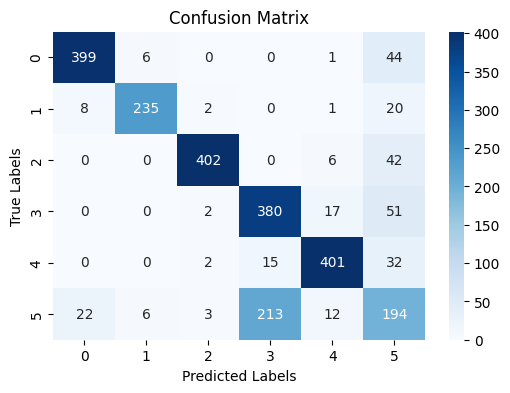

In [18]:
results = model.predict(X_test1,threshold,a,b,known_labels)
print(accuracy_score(y_test,results))
print("\nClassification Report:\n", classification_report(y_test, results))
cm = confusion_matrix(y_test, results)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [99]:
class MahalanobisLayer:
    def __init__(self, alpha=1e-5):
        self.centroids = None
        self.covariance_inv = None
        self.class_labels = None
        self.alpha = alpha  # Regularization for covariance stability

    def fit(self, X_train, y_train):
        self.class_labels = np.unique(y_train)
        self.centroids = []
        self.covariance_inv = []
        for label in self.class_labels:
            class_data = X_train[y_train == label]
            centroid = np.mean(class_data, axis=0)
            cov = np.cov(class_data.T) + np.eye(class_data.shape[1]) * self.alpha
            self.centroids.append(centroid)
            self.covariance_inv.append(np.linalg.inv(cov))
        return self
    def predict(self, X):
        n_classes = len(self.centroids)
        predictions = []
        for x in X:
            distances = np.zeros(n_classes)
            for j in range(n_classes):  
                    distances[j] = mahalanobis(x, self.centroids[j], self.covariance_inv[j])
            distances = np.where(np.isnan(distances), float('inf'), distances)
            predictions.append(distances)
        return np.array(predictions)
class MultiLayerMahalanobis:
    def __init__(self, n_layers=2, alpha=1e-5, n_neighbors=4):
        self.layers = [MahalanobisLayer(alpha) for _ in range(n_layers)]
        #self.preprocessor = DataPreprocessor()
        self.n_layers = n_layers
        self.n_neighbors = n_neighbors
        self.X_train_features = None
        self.y_train = None
        self.class_labels = None

    def gelu(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

    def fit(self, X_current, y_train):
        #X_current = self.preprocessor.preprocess(X_train, fit_scalers=True)
        for i, layer in enumerate(self.layers):
            layer.fit(X_current, y_train)
            X_current = layer.predict(X_current)
            if i < self.n_layers - 1:
                X_current = self.gelu(X_current)
        self.X_train_features = X_current
        self.y_train = y_train
        self.class_labels = np.unique(y_train)
        return self

    def predict(self, X_test,thresholds,a,b,labels):
        
        X_current = X_test[:]
        for i, layer in enumerate(self.layers):
            X_current = layer.predict(X_current)
            # if i < self.n_layers - 1:
            #     X_current = self.gelu(X_current)
        X_test_features = X_current

        # Relational classification using wvRN
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='cosine')
        nn.fit(self.X_train_features)
        distances, indices = nn.kneighbors(X_test_features)
        weights = 1 / (distances_nn + 1e-8)# Convert distance to similarity

        y_pred = []
        for i in range(len(X_test_features)):
            dists = np.array([mahalanobis(X_test[i], a[j], b[j]) for j in range(len(a))])
            min_idx = np.argmin(dists)
            min_dist = dists[min_idx]
            pred_label = labels[min_idx]
            if min_dist > thresholds[pred_label]:
                 y_pred.append(5)
            else:
                neighbor_labels = self.y_train.iloc[indices[i]]
                neighbor_weights = weights[i]
                class_weights = {c: np.sum(neighbor_weights[neighbor_labels == c]) 
                                 for c in self.class_labels}
                total_weight = np.sum(neighbor_weights)
                predicted_class = max(class_weights, key=lambda c: class_weights[c] / total_weight if total_weight > 0 else 0)
                y_pred.append(predicted_class)
        return np.array(y_pred)
    def predict1(self, X_current):
        for i, layer in enumerate(self.layers):
            X_current = layer.predict(X_current)
            # if i < self.n_layers - 1:
            #     X_current = self.gelu(X_current)
        X_test_features = X_current

        # Relational classification using wvRN
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='cosine')
        nn.fit(self.X_train_features)
        distances, indices = nn.kneighbors(X_test_features)
        weights = 1 / (distances + 1e-8) # Convert distance to similarity

        y_pred = []
        for i in range(len(X_test_features)):
            neighbor_labels = self.y_train.iloc[indices[i]]
            neighbor_weights = weights[i]
            class_weights = {c: np.sum(neighbor_weights[neighbor_labels == c]) 
                             for c in self.class_labels}
            total_weight = np.sum(neighbor_weights)
            predicted_class = max(class_weights, key=lambda c: class_weights[c] / total_weight if total_weight > 0 else 0)
            y_pred.append(predicted_class)
        return np.array(y_pred)

In [122]:
def load_data(max_samples_per_class=1500):
    """datasets = {
        "BF1_DDoS_1": "d4_csv/BF1_DDoS_1.pcap_Flow.csv",
        "BF1_DoS_1": "d4_csv/BF1_DoS_1.pcap_Flow.csv",
        "Delay_DDoS_1": "d4_csv/Delay_DDoS_1.pcap_Flow.csv",
        "Delay_DoS_1": "d4_csv/Delay_DoS_1.pcap_Flow.csv",
        "Normal1": "d4_csv/Normal1.pcap_Flow.csv",
        "Sub_DDoS_1": "d4_csv/Sub_DDoS_1.pcap_Flow.csv",
        "Sub_DoS_1": "d4_csv/Sub_DoS_1.pcap_Flow.csv",
        "SYN_DDoS_1": "d4_csv/SYN_DDoS_1.pcap_Flow.csv",
        "SYN_DoS_1": "d4_csv/SYN_DoS1.pcap_Flow.csv",
        "WILL_DDoS_1": "d4_csv/WILL_DDoS_1.pcap_Flow.csv",
        "WILL_DoS_1": "d4_csv/WILL_DoS_1.pcap_Flow.csv"
    }

    class_labels = {
        "BF1_DDoS_1": 0, "BF1_DoS_1": 1, "Delay_DDoS_1": 2, "Delay_DoS_1": 3, "Normal1": 4, 
        "Sub_DDoS_1": 5,"Sub_DoS_1": 6, "SYN_DDoS_1": 7, "SYN_DoS_1": 8, "WILL_DDoS_1": 9, "WILL_DoS_1": 10}"""
    datasets = {
        "normal": "d1_csv/normal.csv",
        "ddos_connectflood": "d1_csv/dos_publish_flood.csv",
        "ddos_publish_flood": "d1_csv/ddos_publish_flood.csv",
        "dos_publish_flood": "d1_csv/dos_connectflood.csv",
        "dos_connectflood": "d1_csv/ddos_connectflood.csv",
        "malformed": "d1_csv/malformed.csv"
    }
    class_labels = {
        "normal": 0,
        "ddos_connectflood": 1,
        "ddos_publish_flood": 2,
        "dos_publish_flood": 3,
        "dos_connectflood": 4,
        "malformed": 5
    }

    all_data = []
    for attack, file in datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        # df = df[features]
        df["Class"] = class_labels[attack]
        df = df.sample(n=min(len(df),max_samples_per_class), random_state=42,replace = True)
        all_data.append(df)
    
    full_df = pd.concat(all_data, ignore_index=True)
    train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=41, stratify=full_df["Class"])
    return train_df, test_df
scaler2 = StandardScaler()
def preprocess(df, fit_scalers=True):
    df = df.drop(columns=['Flow ID', 'Src IP', 'Dst IP',  'Timestamp', 'Label'], errors='ignore')
    
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

    # Handle infinities and NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)  

    # Scaling
    if fit_scalers:
        x_pca = scaler2.fit_transform(df)
    else:
        x_pca = scaler2.transform(df)

    return x_pca

In [123]:
train_df, test_df= load_data()


In [124]:

y_train = train_df["Class"]
y_test = test_df["Class"]


train_df = train_df.drop("Class", axis=1)
test_df = test_df.drop("Class", axis=1)

X_train = preprocess(train_df, fit_scalers=True)
X_test = preprocess(test_df, fit_scalers=False)


In [127]:
model = MultiLayerMahalanobis(n_layers=1, alpha=1e-6,n_neighbors=5)
model.fit(X_train, y_train)

0.9606674612634089

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       300
           1       0.96      0.96      0.96       178
           2       0.97      0.98      0.98       300
           3       0.95      0.94      0.95       300
           4       0.94      0.95      0.94       300
           5       0.98      0.97      0.97       300

    accuracy                           0.96      1678
   macro avg       0.96      0.96      0.96      1678
weighted avg       0.96      0.96      0.96      1678



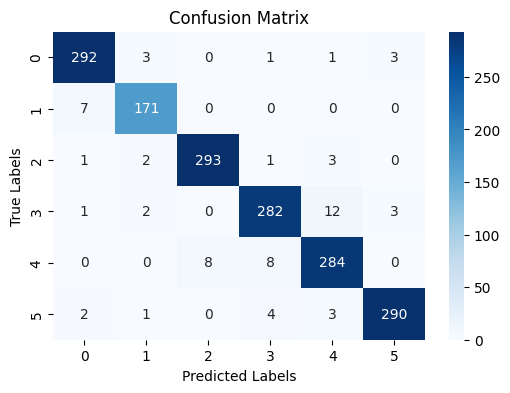

In [128]:
results = model.predict1(X_test)
print(accuracy_score(y_test,results))
print("\nClassification Report:\n", classification_report(y_test, results))
cm = confusion_matrix(y_test, results)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dt_model = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5900

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.65      0.63       300
           1       0.69      0.65      0.67       300
           2       0.57      0.61      0.59       300
           3       0.39      0.42      0.40       300
           4       0.30      0.29      0.29       300
           5       0.54      0.46      0.50       300
           6       0.77      0.80      0.78       300
           7       0.39      0.38      0.39       300
           8       0.85      0.86      0.86       300
           9       0.66      0.66      0.66       300
          10       0.69      0.73      0.71       300

    accuracy                           0.59      3300
   macro avg       0.59      0.59      0.59      3300
weighted avg       0.59      0.59      0.59      3300


Confusion Matrix:
 [[194  26  25  23  10   7   0   4   0   5   6]
 [ 29 194  13  35   8   2   0   2   0   8   9]
 [ 30   7 183  25  16  12   3  

In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize KNN model with k=5 (you can tune this)
knn_model = KNeighborsClassifier(n_neighbors=3, metric='euclidean', n_jobs=-1)

# Train the model
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5079

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.51      0.41       300
           1       0.47      0.52      0.49       300
           2       0.47      0.56      0.51       300
           3       0.22      0.23      0.23       300
           4       0.30      0.32      0.31       300
           5       0.58      0.46      0.51       300
           6       0.79      0.73      0.76       300
           7       0.37      0.29      0.32       300
           8       0.86      0.83      0.84       300
           9       0.64      0.52      0.57       300
          10       0.70      0.63      0.66       300

    accuracy                           0.51      3300
   macro avg       0.52      0.51      0.51      3300
weighted avg       0.52      0.51      0.51      3300


Confusion Matrix:
 [[153  48  39  33  13   6   1   5   0   1   1]
 [ 64 155  14  25   9   1   0   5   0  21   6]
 [ 53  14 167  24  23   4   1  

In [47]:

from sklearn.decomposition import TruncatedSVD, KernelPCA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [64]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import defaultdict



import pandas as pd
from sklearn.model_selection import train_test_split

def load_data():


    datasets={
        "bruteforce":"dataset3/d3_bruteforce_payload_clean.csv",   
        "capture_1w":"dataset3/d3_capture_1w_payload_clean.csv",
        "capture_flood":"dataset3/d3_capture_flood_payload_clean.csv",
        "malariaDoS":"dataset3/d3_capture_malariaDoS_payload_clean.csv",
        "malformed":"dataset3/d3_malformed_payload_clean.csv",
       #"slowite":"dataset3/d3_slowite_payload_clean.csv",
        
    }
    class_labels = {
        "bruteforce": 0,
        "capture_1w": 1,
        "capture_flood": 2,
        "malariaDoS": 3,
        "malformed": 4  ,
        "slowite":5
    }
    

    all_data = []
    payload_class_count = {}

    # First Pass: Count payload occurrences across classes
    for attack, file in datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        print(len(df))

        if "Payload (Hex)" in df.columns:
            for payload in df["Payload (Hex)"].dropna().unique():
                payload_class_count[payload] = payload_class_count.get(payload, 0) + 1

    # Second Pass: Load data but exclude multi-class payloads
    for attack, file in datasets.items():
        df = pd.read_csv(file, encoding='latin1')
        df["Class"] = class_labels[attack]

        if "Payload (Hex)" in df.columns:
            df = df[df["Payload (Hex)"].notna()]
            df = df[df["Payload (Hex)"].apply(lambda x: payload_class_count.get(x, 0) == 1)]  # Ensure key exists
        

        if len(df) > 2000:
            df = df.sample(n=2000, random_state=42)  # Sampling for balance

        all_data.append(df)

    full_df = pd.concat(all_data, ignore_index=True)

    print("Class Distribution After Filtering:\n", full_df["Class"].value_counts())

    train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df["Class"])
    

    train_df["Payload Text"] = train_df["Payload (Hex)"].astype(str)
    test_df["Payload Text"] = test_df["Payload (Hex)"].astype(str)
    train_new_df, valid_df = train_test_split(train_df, test_size=0.8, random_state=42, stratify=train_df["Class"])
    unknown_df = pd.read_csv("dataset3/d3_slowite_payload_clean.csv", encoding='latin1')
    print(f"malformed shape: {unknown_df.shape}")
    unknown_df["Class"] = 5
    unknown_df = unknown_df.sample(n=min(len(unknown_df), 500), random_state=42)
    unknown_df["Payload Text"] = unknown_df["Payload (Hex)"].astype(str)
    test_df = pd.concat([test_df, unknown_df], ignore_index=True)
    return train_new_df,valid_df, test_df




    





def extract_features(train_df,valid_df, test_df, n_components=50):
    print("Extracting TF-IDF features...")
    scaler=StandardScaler()
    tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=2500)
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Payload Text"])
    X_valid_tfidf = tfidf_vectorizer.transform(valid_df["Payload Text"])
    X_test_tfidf = tfidf_vectorizer.transform(test_df["Payload Text"])
    print("TF-IDF feature extraction complete!")

    # Dimensionality Reduction using Truncated SVD
    print("Applying Truncated SVD...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_reduced = svd.fit_transform(X_train_tfidf)
    X_valid_reduced = svd.transform(X_valid_tfidf)
    X_test_reduced = svd.transform(X_test_tfidf)
    
    print(f"Reduced dimensions: {X_train_reduced.shape}")


    X_train = scaler.fit_transform(X_train_reduced)
    X_valid = scaler.transform(X_valid_reduced)
    X_test = scaler.transform(X_test_reduced)
    return X_train,X_valid,X_test, train_df["Class"],valid_df["Class"],test_df["Class"]


def balance_data(X_train, y_train):
    print("Applying SMOTE...")
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"SMOTE Applied: Resampled Training Size = {X_train_resampled.shape}")

    return X_train_resampled, y_train_resampled


def compute_class_statistics(X_train, y_train):
    centroids = []
    covariance_inv = []
    class_labels = np.unique(y_train)

    for label in class_labels:
        class_data = X_train[y_train == label]
        
        centroid = np.mean(class_data, axis=0)
        centroids.append(centroid)
        
        cov_matrix = np.cov(class_data.T, rowvar=True)
        
        # Ensure covariance matrix is invertible
        cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
        cov_inv = np.linalg.inv(cov_matrix)
        
        covariance_inv.append(cov_inv)

    return centroids, covariance_inv, class_labels


def train_model(X_train, y_train):
    centroids, covariance_inv, class_labels = compute_class_statistics(X_train, y_train)
    return centroids, covariance_inv, class_labels


def predict(X_test, centroids, covariance_inv, class_labels):
    predictions = []

    for x in X_test:
        distances = [mahalanobis(x, centroids[j], covariance_inv[j]) for j in range(len(centroids))]
        predictions.append(class_labels[np.argmin(distances)])

    return np.array(predictions)


def evaluate_model(centroids, covariance_inv, class_labels, X_test, y_test):
    print("\n Evaluating Model on Test Data...")
    y_pred = predict(X_test, centroids, covariance_inv, class_labels)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    
    print("\nConfusion Matrix:\n", cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()




In [65]:
train_df,valid_df,test_df = load_data()

874
286289
285
47909
2517
Class Distribution After Filtering:
 Class
1    2000
3    2000
4    1822
0     862
2     285
Name: count, dtype: int64
malformed shape: (1016, 4)


In [66]:
X_train,X_valid,X_test, y_train,y_valid, y_test = extract_features(train_df,valid_df, test_df)

Extracting TF-IDF features...
TF-IDF feature extraction complete!
Applying Truncated SVD...
Reduced dimensions: (1115, 50)


In [ ]:
print(X_test[1595])
print(y_test.head(5))
print(X_test[0])
print(y_test[0])

In [74]:
import networkx as nx
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import LabelEncoder
class MahalanobisLayer:
    def __init__(self, alpha=1e-5):
        self.centroids = None
        self.covariance_inv = None
        self.class_labels = None
        self.alpha = alpha

    def fit(self, X_train, y_train):
        self.class_labels = np.unique(y_train)
        self.centroids = []
        self.covariance_inv = []
        for label in self.class_labels:
            class_data = X_train[y_train == label]
            centroid = np.mean(class_data, axis=0)
            cov = np.cov(class_data.T) + np.eye(class_data.shape[1]) * self.alpha
            self.centroids.append(centroid)
            self.covariance_inv.append(np.linalg.inv(cov))
        return self

    def compute_distances(self, X):
        n_classes = len(self.centroids)
        distances = []
        for x in X:
            dist = np.zeros(n_classes)
            for j in range(n_classes):
                dist[j] = mahalanobis(x, self.centroids[j], self.covariance_inv[j])
            dist = np.where(np.isnan(dist), float('inf'), dist)
            distances.append(dist)
        return np.array(distances)


class GridGraphClassifier:
    def __init__(self, n_bins=20):
        self.n_bins = n_bins
        self.graph = None
        self.cell_labels = {}
        self.class_labels = None  # Store class labels
        self.bin_edges_list = None  # To store bin edges for each dimension

    def _compute_bin_edges(self, distances):
        """Compute and store bin edges for each dimension using the training data."""
        n_classes = distances.shape[1]
        self.bin_edges_list = []
        for i in range(n_classes):
            percentiles = np.linspace(0, 100, self.n_bins + 1)
            # Compute bin edges from the training distances for each feature/dimension.
            bin_edges = np.percentile(distances[:, i], percentiles)
            self.bin_edges_list.append(bin_edges)

    def _discretize_features(self, distances):
        """Discretize features using precomputed bin edges (if available), or compute them."""
        n_classes = distances.shape[1]
        cell_indices = np.zeros_like(distances, dtype=int)
        if self.bin_edges_list is not None:
            for i in range(n_classes):
                bin_edges = self.bin_edges_list[i]
                cell_indices[:, i] = np.digitize(distances[:, i], bin_edges, right=False) - 1
                cell_indices[:, i] = np.clip(cell_indices[:, i], 0, self.n_bins - 1)
        else:
            # If not, compute bin edges on the fly (this case should occur during training).
            for i in range(n_classes):
                percentiles = np.linspace(0, 100, self.n_bins + 1)
                bin_edges = np.percentile(distances[:, i], percentiles)
                cell_indices[:, i] = np.digitize(distances[:, i], bin_edges, right=False) - 1
                cell_indices[:, i] = np.clip(cell_indices[:, i], 0, self.n_bins - 1)
        return cell_indices

    def _build_grid_graph(self, cell_indices):
        self.graph = nx.Graph()
        unique_cells = np.unique(cell_indices, axis=0)
        for cell in unique_cells:
            self.graph.add_node(tuple(cell))
        for i, cell1 in enumerate(unique_cells):
            for cell2 in unique_cells[i+1:]:
                diff = np.abs(cell1 - cell2)
                if np.sum(diff) == 1 and np.max(diff) == 1:
                    self.graph.add_edge(tuple(cell1), tuple(cell2))

    def _assign_initial_labels(self, cell_indices, y_train):
        for idx, cell in enumerate(cell_indices):
            cell_tuple = tuple(cell)
            if cell_tuple not in self.cell_labels:
                self.cell_labels[cell_tuple] = []
            self.cell_labels[cell_tuple].append(y_train[idx])
        for cell in self.cell_labels:
            labels = np.array(self.cell_labels[cell])
            unique, counts = np.unique(labels, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            self.cell_labels[cell] = majority_label
#fork 1

    def fit(self, X_train, y_train, mahalanobis_layer):
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        self.class_labels = mahalanobis_layer.class_labels
        distances = mahalanobis_layer.compute_distances(X_train)
        # Compute and store bin edges from training data
        self._compute_bin_edges(distances)
        cell_indices = self._discretize_features(distances)
        self._build_grid_graph(cell_indices)
        self._assign_initial_labels(cell_indices, y_train)
        return self


    def predict(self, X, mahalanobis_layer):
        X = np.asarray(X)
        distances = mahalanobis_layer.compute_distances(X)
        cell_indices = self._discretize_features(distances)

        predictions = []
        for cell in cell_indices:
            cell_tuple = tuple(cell)
            if cell_tuple in self.cell_labels and self.cell_labels[cell_tuple] is not None:
                predictions.append(self.cell_labels[cell_tuple])
            else:
                nearest_label = self._check_one_step_neighbors(cell_tuple)
                predictions.append(nearest_label)
        return np.array(predictions)

    def _check_one_step_neighbors(self, cell):
        cell = np.array(cell)
        for dim in range(len(cell)):
            for delta in [-1, 1]:
                neighbor = cell.copy()
                neighbor[dim] += delta
                neighbor_tuple = tuple(neighbor)
                if neighbor_tuple in self.cell_labels and self.cell_labels[neighbor_tuple] is not None:
                    return self.cell_labels[neighbor_tuple]
        return 5  # fallback class

In [71]:
mahalanobis_layer = MahalanobisLayer(alpha=1e-15)
mahalanobis_layer.fit(X_train, y_train)

In [75]:
grid_classifier = GridGraphClassifier(n_bins=10)
grid_classifier.fit(X_valid, y_valid, mahalanobis_layer)

C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\spatial\distance.py:1035: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
C:\Users\vasir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0.7360084477296727

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       172
           1       1.00      1.00      1.00       400
           2       0.80      1.00      0.89        57
           3       0.61      0.99      0.75       400
           4       0.62      0.99      0.76       365
           5       0.67      0.02      0.04       500

    accuracy                           0.74      1894
   macro avg       0.78      0.83      0.74      1894
weighted avg       0.75      0.74      0.64      1894



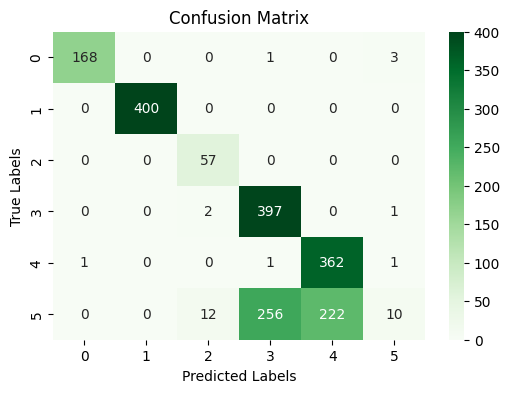

In [76]:
results = grid_classifier.predict(X_test, mahalanobis_layer)
print(accuracy_score(y_test,results))
print("\nClassification Report:\n", classification_report(y_test, results))
cm = confusion_matrix(y_test, results)

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()